## Generating Rectangulations

### Suppose we carve up a square with vertical and horizontal dividers, so that each internal cell is rectangular in shape. These will henceforth be refered to as 'rectangulations'.

### Now, it would be nice* to have a collection of all of the rectangulations with a certain number of internal cells. We are looking to build an algorithm that takes the form: 

### Number of cells (integer input > 1) <strong>&#8594;</strong> set of rectangulations (image output).

*practical motivation for the work will be discussed in a later section.

<img src="rectangulation_4.png" width="400">

### Above, you can see all rectangulations with 4 internal cells. 

### You'll notice there are quite few. We are not burdening the visual field with all of the rotations and reflections. 

### With symmetries, there are 25 symbols; without, there are only 7. 

### Our goal might be assisted by <a href="https://math.stackexchange.com/questions/1116/number-of-ways-to-partition-a-rectangle-into-n-sub-rectangles" target="_blank">looking at community postings</a>.

- [2010/2014] The work of Jim Conant and Tim Michaels gives a function which tells how many rectangulations with symmetries will be given for a certain number of cells (ie 25 for 4 cells). The math used is a bit on the tough side. The process of 'pushing in an edge from the side in all possible ways' is a particular challenge for me.
<br><br>
- [2011, 2012] Nathan Reading provides an interesting paper which appears to give a simple relation between permutations and rectangulations, however it only applies to rectangulations of the 'generic' type, and it also requires an operation referred to as 'wall-slides', which add an annoying obstacle to writing a computer algorithm.
<br><br>
- A tiny comment from 2010 by Matt Calhoun seems to describe the approach that I independently arrived at.


#### "Given a square of side L that includes V vertical and H horizontal lines each of length L, then the number of internal rectangles is R = (V+1)(H+1). Now we can begin subtracting portions of these vertical and horizontal lines one at a time to subtract one internal rectangle (R -> R-1); but we can only remove portions of lines if this creates a rectangle and not some other shape (see the second diagram in the OP to make this clear). The problem now becomes related to counting the number of ways we can delete line portions without creating non-rectangle shapes inside the original square."

### The diagram he refers to is lost, however I will provide my own below:

<img src="Rectangulations_Diagram2.png" width="800">

## Hierarchy of functions used:


- draw_matrix / draw_matrices
    - get_node_y_pos
        - get_first_row_order
            - get_top_left_index
        - get_node_row
    - get_node_x_pos
        - get_first_col_order
            - get_top_left_index
        - get_node_col
    - count_cells_in_matrix
    
- gather_rectangulations
    - generate_grid_matrix
    - edge_removable
    - remove_edge
    - standardize_matrix
        - get_col_map
            - get_first_row_order
                - get_top_left_index
            - get_node_row
        - get_row_map
    - matrix_in_list
    - remove_floating_nodes
    - symmetries_of_matrix
        - v_multi_by_i
        - v_complex_conj

In [1]:
import numpy as np

In [2]:
mult_i = { '1':  'i', 
           'i': '-1', 
          '-1': '-i',
          '-i':  '1',
           '0':  '0'}

In [3]:
conjug = { '1':  '1', 
           'i': '-i', 
          '-1': '-1',
          '-i':  'i',
           '0':  '0'}

In [4]:
def multi_by_i(x):
    return mult_i[x]

def complex_conj(x):
    return conjug[x]

v_multi_by_i = np.vectorize(multi_by_i)

v_complex_conj = np.vectorize(complex_conj)

In [5]:
def get_top_left_index(arr):
    for i in range(arr.shape[1]):
        col = arr[:, i]
        if '-1' in col and '1' not in col and 'i' in col and '-i' not in col:
            return i
    return -1 # throw an error

In [6]:
def get_first_row_order(arr):
    
    idx = get_top_left_index(arr)
    idy = np.where(arr[:, idx] == '-1')[0][0]
    col_map = np.array([idx])
    
    for i in range(arr.shape[1]):
        idx = np.where(arr[idy] == '1')[0][0] #in what row is this new point considered left?
        col_map = np.append(col_map, idx)
            
        idy_arr = np.where(arr[:, idx] == '-1')[0]
        if(idy_arr.size != 0): #if this point 
            idy = idy_arr[0]
        else:
            break
            
    return col_map

In [7]:
def get_node_row(arr, node_idx):
    left_partners = np.array([], dtype=np.int64)
    idy_arr = np.where(arr[:, node_idx] == '1')[0] #get row in which initial node is considered 'right'
    for i in range(arr.shape[1]):
        if(idy_arr.size != 0):
            idy = idy_arr[0]
            idx = np.where(arr[idy] == '-1')[0][0]
            left_partners = np.append(left_partners, idx)
            idy_arr = np.where(arr[:, idx] == '1')[0]
        else:
            break
            
    right_partners = np.array([], dtype=np.int64)
    idy_arr = np.where(arr[:, node_idx] == '-1')[0] #get row in which initial node is considered 'left'
    for i in range(arr.shape[1]):
        if(idy_arr.size != 0):
            idy = idy_arr[0]
            idx = np.where(arr[idy] == '1')[0][0]
            right_partners = np.append(right_partners, idx)
            idy_arr = np.where(arr[:, idx] == '-1')[0]
        else:
            break
            
    left_partners = left_partners[::-1]
    node_row = np.concatenate([left_partners, np.array([node_idx]), right_partners])
    return node_row

In [8]:
def get_node_col(arr, node_idx):
    upper_partners = np.array([], dtype=np.int64)
    idy_arr = np.where(arr[:, node_idx] == '-i')[0] #get row in which initial node is considered 'down'
    for i in range(arr.shape[1]):
        if(idy_arr.size != 0):
            idy = idy_arr[0]
            idx = np.where(arr[idy] == 'i')[0][0]
            upper_partners = np.append(upper_partners, idx)
            idy_arr = np.where(arr[:, idx] == '-i')[0]
        else:
            break
            
    lower_partners = np.array([], dtype=np.int64)
    idy_arr = np.where(arr[:, node_idx] == 'i')[0] #get row in which initial node is considered 'up'
    for i in range(arr.shape[1]):
        if(idy_arr.size != 0):
            idy = idy_arr[0]
            idx = np.where(arr[idy] == '-i')[0][0]
            lower_partners = np.append(lower_partners, idx)
            idy_arr = np.where(arr[:, idx] == 'i')[0]
        else:
            break
    
    upper_partners = upper_partners[::-1]
    node_row = np.concatenate([upper_partners, np.array([node_idx]), lower_partners])
    return node_row

In [9]:
def get_col_map(arr):
    node_row = get_first_row_order(arr)
    col_map = node_row[:]
    for x in range(arr.shape[1]): #the number of node-rows is less than the number of rows, but unknown initially
        row_candidates = np.array([], dtype=np.int64)
        if x == 0:
            temp_col_map = col_map[:]
        else:
            split_index = col_map.size - node_row.size
            temp_col_map = np.concatenate([col_map[split_index:],  col_map[:split_index]])
        for i in temp_col_map:
            if 'i' in arr[:, i]: #node is upstairs of another: 'i' in column
                idy = np.where(arr[:, i] == 'i')[0][0] # get the row index that has the 'i'
                idx = np.where(arr[idy] == '-i')[0][0] # get the column index that has the '-i'
                if(idx not in col_map):
                    row_candidates = np.append(row_candidates, idx)
        if row_candidates.size != 0:
            node_row = np.array([], dtype=np.int64)
            for row_cand in row_candidates:
                row_partners = get_node_row(arr, row_cand)
                # for each node in the node row,
                # check if the upstairs neighbors are in the set already visited (col_map)
                anomaly = False
                for partner in row_partners:
                    if '-i' in arr[:, partner]: #node is downstairs of another: '-i' in column
                        idy = np.where(arr[:, partner] == '-i')[0][0] # get the row index that has the '-i'
                        idx = np.where(arr[idy] == 'i')[0][0] # get the column index that has the 'i'
                        if idx not in col_map: # idx should be upstairs neighbor of partner
                            anomaly = True
                            break
                if not anomaly: #if the row is 'good'
                    mask = np.isin(row_partners, col_map, invert=True)
                    row_partners = row_partners[mask]
                    
                    mask = np.isin(row_partners, node_row, invert=True)
                    row_partners = row_partners[mask]
                    
                    node_row = np.append(node_row, row_partners)
                    
            if(node_row.size != 0):
                col_map = np.append(col_map, node_row) #add the row_partners not already in col_map

        else: # if fin with the last row, then return col_map
            return col_map

In [10]:
def get_row_map(arr):
    #assumes input is an array with columns already sorted
    real_part = []
    for i in range(len(arr[0])):
        if '-1' in arr[:, i]:
            idy = np.where(arr[:, i] == '-1')[0][0]
            real_part += [idy]
            
    complex_part = []
    for i in range(len(arr[0])):
        if 'i' in arr[:, i]:
            idy = np.where(arr[:, i] == 'i')[0][0]
            complex_part += [idy]
            
    return real_part + complex_part

In [11]:
def standardize_matrix(arr):
    col_map = get_col_map(arr)
    arr = arr[:, col_map]
    row_map = get_row_map(arr)
    arr = arr[row_map, :]
    return arr

In [12]:
def get_first_col_order(arr):
        
    idx = get_top_left_index(arr)
    idy = np.where(arr[:, idx] == 'i')[0][0]
    row_map = np.array([idx])
    
    for i in range(arr.shape[1]):
        idx = np.where(arr[idy] == '-i')[0][0] #in what row is this new point considered up?
        row_map = np.append(row_map, idx)
            
        idy_arr = np.where(arr[:, idx] == 'i')[0]
        if(idy_arr.size != 0):
            idy = idy_arr[0]
        else:
            break
            
    return row_map

In [13]:
def get_node_y_pos(arr):
    #lists the positions of nodes on the y axis by index
    #assumes input is an array with the columns already sorted
    node_row = get_first_row_order(arr)
    rows = []
    rows.append(node_row.tolist())
    col_map = node_row[:]
    for x in range(arr.shape[1]): #the number of node-rows is less than the number of rows, but unknown initially
        row_candidates = np.array([], dtype=np.int64)
        if x == 0:
            temp_col_map = col_map[:]
        else:
            split_index = col_map.size - node_row.size
            temp_col_map = np.concatenate([col_map[split_index:],  col_map[:split_index]])
        for i in temp_col_map:
            if 'i' in arr[:, i]: #node is upstairs of another: 'i' in column
                idy = np.where(arr[:, i] == 'i')[0][0] # get the row index that has the 'i'
                idx = np.where(arr[idy] == '-i')[0][0] # get the column index that has the '-i'
                if(idx not in col_map):
                    row_candidates = np.append(row_candidates, idx)
        if row_candidates.size != 0:
            node_row = np.array([], dtype=np.int64)
            for row_cand in row_candidates:
                row_partners = get_node_row(arr, row_cand)
                # for each node in the node row,
                # check if the upstairs neighbors are in the set already visited (col_map)
                anomaly = False
                for partner in row_partners:
                    if '-i' in arr[:, partner]: #node is downstairs of another: '-i' in column
                        idy = np.where(arr[:, partner] == '-i')[0][0] # get the row index that has the '-i'
                        idx = np.where(arr[idy] == 'i')[0][0] # get the column index that has the 'i'
                        if idx not in col_map: # idx is upstairs neighbor of partner-node
                            anomaly = True
                            break
                if not anomaly: #if the row is 'good'
                    mask = np.isin(row_partners, col_map, invert=True)
                    row_partners = row_partners[mask]
                    
                    mask = np.isin(row_partners, node_row, invert=True)
                    row_partners = row_partners[mask]

                    node_row = np.append(node_row, row_partners)

            if node_row.size != 0:
                col_map = np.append(col_map, node_row) #add the row_partners not already in col_map
                #                                       which have been accumulating in node_row
                rows.append(node_row.tolist())
        else: # if fin with the last row, then return rows
            #print(rows)
            result = []
            for rowI in range(len(rows)):
                for item in rows[rowI]:
                    result += [rowI]
            return result 

In [14]:
def get_node_x_pos(arr):
    node_col = get_first_col_order(arr)
    cols = []
    cols.append(node_col.tolist())
    row_map = node_col[:]
    for x in range(arr.shape[1]): #the number of node-cols is less than the number of rows, but unknown initially
        col_candidates = np.array([], dtype=np.int64)
        if x == 0:
            temp_row_map = row_map[:]
        else:
            split_index = row_map.size - node_col.size
            temp_row_map = np.concatenate([row_map[split_index:],  row_map[:split_index]])
        for i in temp_row_map:
            if '-1' in arr[:, i]: #node is left of another: '1' in column
                idy = np.where(arr[:, i] == '-1')[0][0] # get the row index that has the '-1'
                idx = np.where(arr[idy] == '1')[0][0] # get the column index that has the '1'
                if(idx not in row_map):
                    col_candidates = np.append(col_candidates, idx)
        if col_candidates.size != 0:
            node_col = np.array([], dtype=np.int64)
            for col_cand in col_candidates:
                col_partners = get_node_col(arr, col_cand)
                # for each node in the node col,
                # check if the leftward neighbors are in the set already visited (col_map)
                anomaly = False
                for partner in col_partners:
                    if '1' in arr[:, partner]: #node is right of another: '1' in column
                        idy = np.where(arr[:, partner] == '1')[0][0] # get the row index that has the '1'
                        idx = np.where(arr[idy] == '-1')[0][0] # get the column index that has the '-1'
                        if idx not in row_map: # idx is the left neighbor of partner-node
                            anomaly = True
                            break
                if not anomaly: #if the col is 'good'
                    mask = np.isin(col_partners, row_map, invert=True)
                    col_partners = col_partners[mask]
                                        
                    mask = np.isin(col_partners, node_col, invert=True)
                    col_partners = col_partners[mask]
                    
                    node_col = np.append(node_col, col_partners)
                    
            if node_col.size != 0:
                row_map = np.append(row_map, node_col) #add the col_partners not already in row_map (accum. in node_col)
                cols.append(node_col.tolist())

        else: # if fin with the last row, then return rows
            result = [0]*arr.shape[1]
            for colI in range(len(cols)):
                for item in cols[colI]:
                    result[item] = colI
            return result 

In [15]:
import matplotlib.pyplot as plt

In [16]:
def count_cells_in_matrix(arr):
    num = 0
    for i in range(arr.shape[1]):
        if '-1' in arr[:, i] and '-i' in arr[:, i]: #count bottom left corners
            num += 1
    return num

In [17]:
def draw_matrix(arr, save_file="False", index=0):
    #assumes incidence matrix has columns and rows sorted
    x_pos = get_node_x_pos(arr)
    y_pos = get_node_y_pos(arr)
    #print(y_pos)
    
    max_x = x_pos[-1]
    max_y = y_pos[-1]
    
    x_pos = [x/max_x for x in x_pos]
    y_pos = [(max_y - y)/max_y for y in y_pos]
    
    num_cells = count_cells_in_matrix(arr) 
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    
    for i in range(arr.shape[0]): #for each edge
        if '1' in arr[i]: #if edge is horizontal
            left_node_index = np.where(arr[i] == '-1')[0][0]
            right_node_index = np.where(arr[i] == '1')[0][0]
            ax.axhline(y=y_pos[left_node_index], xmin=x_pos[left_node_index], xmax=x_pos[right_node_index])
        if 'i' in arr[i]: #if edge is vertical
            bottom_node_index = np.where(arr[i] == '-i')[0][0]
            top_node_index = np.where(arr[i] == 'i')[0][0]
            ax.axvline(x=x_pos[bottom_node_index], ymin=y_pos[bottom_node_index], ymax=y_pos[top_node_index])
    
    if(save_file != "False"):
        plt.savefig(save_file+".png", pad_inches=0)
    #TODO: provide option to save file(s)

In [18]:
import math

In [19]:
def generate_grid_matrix(vertical_dividers, horizontal_dividers):
    cells_wide = vertical_dividers + 1
    cells_tall = horizontal_dividers + 1
    nodes = (cells_wide + 1) * (cells_tall + 1)
    edges = 2 * cells_wide * cells_tall + cells_wide + cells_tall
    horiz_edges = cells_wide * (cells_tall + 1)
    
    arr = np.empty([edges, nodes], dtype=object)
    
    for i in range(edges):
        for j in range(nodes):
            arr[i][j] = '0'
    
    for i in range(horiz_edges):
        offset_i = i + math.floor(i/(cells_wide))
        arr[i][offset_i] = '-1'
        arr[i][offset_i+1] = '1'
    
    for i in range(horiz_edges, edges):
        arr[i][i-horiz_edges] = 'i'
        arr[i][(i-horiz_edges)+cells_wide+1] = '-i'
        
    return arr

In [20]:
def remove_edge(arr, index):
    arr = np.delete(arr, index, axis=0)
    return arr

In [21]:
def edge_removable(arr, index):
    edge = arr[index]
    if '1' in edge:
        left_node = np.where(edge=='-1')[0][0]
        right_node = np.where(edge=='1')[0][0]
        if 'i' in arr[:, left_node] and '-i' in arr[:, left_node] and 'i' in arr[:, right_node] and '-i' in arr[:, right_node]:
            return True
    
    if 'i' in edge:
        bottom_node = np.where(edge=='-i')[0][0]
        top_node = np.where(edge=='i')[0][0]
        if '1' in arr[:, bottom_node] and '-1' in arr[:, bottom_node] and '1' in arr[:, top_node] and '-1' in arr[:, top_node]:
            return True
    
    return False

In [22]:
def matrix_in_list(arr, arr_list):
    for i in range(len(arr_list)):
        if np.array_equal(arr, arr_list[i]):
            return True
    return False

In [23]:
def remove_floating_nodes(arr):
    for x in range(2): #in some situations we will have to perform the operation twice [ie H in a box; remove the center edge]
        for i in range(arr.shape[1]):
            col = arr[:,i]
            if 'i' in col and '-i' in col and '1' not in col and '-1' not in col:
                neg_row = np.where(col == '-i')[0][0]
                pos_row = np.where(col == 'i')[0][0]
                far_neg_col = np.where(arr[pos_row] == '-i')[0][0]
                arr[neg_row][i] = '0'
                arr[neg_row][far_neg_col] = '-i'
                arr = np.delete(arr, pos_row, axis=0)
                arr = np.delete(arr, i, axis=1)
                break
            if '1' in col and '-1' in col and 'i' not in col and '-i' not in col:
                neg_row = np.where(col == '-1')[0][0]
                pos_row = np.where(col == '1')[0][0]
                far_pos_col = np.where(arr[neg_row] == '1')[0][0]
                arr[pos_row][i] = '0'
                arr[pos_row][far_pos_col] = '1'
                arr = np.delete(arr, neg_row, axis=0)
                arr = np.delete(arr, i, axis=1)
                break      
    return arr

In [24]:
def symmetries_of_matrix(arr):
    symmetries = [arr]
    for i in range(3):
        arr = v_multi_by_i(arr)
        arr = standardize_matrix(arr)
        if not matrix_in_list(arr, symmetries):
            symmetries += [arr]
    arr = v_complex_conj(arr)
    arr = standardize_matrix(arr)
    if not matrix_in_list(arr, symmetries):
        symmetries += [arr]
    for i in range(3):
        arr = v_multi_by_i(arr)
        arr = standardize_matrix(arr)
        if not matrix_in_list(arr, symmetries):
            symmetries += [arr]

    return symmetries

In [25]:
def gather_rectangulations(parts):
    visited_rects = {} #indexed by num_cells
    results = {} # same as above ^
    max_cells = 0
    for i in range(math.ceil(parts/2)):
        grid = generate_grid_matrix(i, parts - (i+1))
        num_cells = count_cells_in_matrix(grid)
        if num_cells > max_cells:
            max_cells = num_cells
        visited_rects[num_cells] = [grid]
        
        results[num_cells] = [grid]
        rotated_grid = v_multi_by_i(grid)
        rotated_grid = standardize_matrix(rotated_grid)
        if not np.array_equal(rotated_grid, grid):
            visited_rects[num_cells] += [rotated_grid]
    
    for i in range(max_cells, parts, -1): #counting down from the highest number of cells created by our grids
        if i in results:
            for j in range(len(results[i])):
                base_matrix = results[i][j]
                for k in range(base_matrix.shape[0]):   # for each edge in result[i][j],
                    is_removable = edge_removable(base_matrix, k) # check if the edge is removable
                    if is_removable: # if edge is removable,
                        reduced_matrix = remove_edge(base_matrix, k)
                        reduced_matrix = remove_floating_nodes(reduced_matrix)
                        reduced_matrix = standardize_matrix(reduced_matrix)
                    else:
                        continue
                    # remove the edge and check if that matrix is visited
                    if not i-1 in visited_rects:
                        is_visited = False
                    else: 
                        is_visited = matrix_in_list(reduced_matrix, visited_rects[i-1])
                            
                    if not is_visited: 
                        
                        #if it is not visited,
                        # add the matrix to results[i-1]
                        if i - 1 in results:
                            results[i-1] += [reduced_matrix]
                        else:
                            results[i-1] = [reduced_matrix]
                            
                        symmetries = symmetries_of_matrix(reduced_matrix)
                        
                        if i - 1 in visited_rects:
                            visited_rects[i - 1] += symmetries
                        else:
                            visited_rects[i - 1] = symmetries
                            

    if parts in results:
        return results[parts]
    else:
        return None

In [26]:
five_cells = gather_rectangulations(5)
five_cells

[array([['-1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
        ['0', '0', '-1', '1', '0', '0', '0', '0', '0', '0', '0', '0'],
        ['0', '0', '0', '0', '-1', '1', '0', '0', '0', '0', '0', '0'],
        ['0', '0', '0', '0', '0', '0', '-1', '1', '0', '0', '0', '0'],
        ['0', '0', '0', '0', '0', '0', '0', '0', '-1', '1', '0', '0'],
        ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '-1', '1'],
        ['i', '0', '-i', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
        ['0', 'i', '0', '-i', '0', '0', '0', '0', '0', '0', '0', '0'],
        ['0', '0', 'i', '0', '-i', '0', '0', '0', '0', '0', '0', '0'],
        ['0', '0', '0', 'i', '0', '-i', '0', '0', '0', '0', '0', '0'],
        ['0', '0', '0', '0', 'i', '0', '-i', '0', '0', '0', '0', '0'],
        ['0', '0', '0', '0', '0', 'i', '0', '-i', '0', '0', '0', '0'],
        ['0', '0', '0', '0', '0', '0', 'i', '0', '-i', '0', '0', '0'],
        ['0', '0', '0', '0', '0', '0', '0', 'i', '0', '-i', '0', '0'],
      

In [27]:
four_cells = gather_rectangulations(4)

In [28]:
def draw_matrices(arr_list, fig_cols=3, save=False):
    #TODO: refine figsize based on number of columns
    
    num_cells = count_cells_in_matrix(arr_list[0]) 
    fig_rows = math.ceil(len(arr_list)/fig_cols)
    
    fig = plt.figure(figsize=[fig_cols, fig_rows])
    
    j = 0
    for arr in arr_list:
        j += 1
        #assumes incidence matrix has columns and rows sorted
        x_pos = get_node_x_pos(arr)
        y_pos = get_node_y_pos(arr)
        #print(y_pos)

        max_x = x_pos[-1]
        max_y = y_pos[-1]

        x_pos = [x/max_x for x in x_pos]
        y_pos = [(max_y - y)/max_y for y in y_pos]


        ax = fig.add_subplot(fig_rows, fig_cols, j)
        ax.set_aspect(1, adjustable='box')
        ax.axis('off')

        for i in range(arr.shape[0]): #for each edge
            if '1' in arr[i]: #if edge is horizontal
                left_node_index = np.where(arr[i] == '-1')[0][0]
                right_node_index = np.where(arr[i] == '1')[0][0]
                ax.axhline(y=y_pos[left_node_index], xmin=x_pos[left_node_index], xmax=x_pos[right_node_index])
            if 'i' in arr[i]: #if edge is vertical
                bottom_node_index = np.where(arr[i] == '-i')[0][0]
                top_node_index = np.where(arr[i] == 'i')[0][0]
                ax.axvline(x=x_pos[bottom_node_index], ymin=y_pos[bottom_node_index], ymax=y_pos[top_node_index])

    if(save):
        plt.savefig("rectangulation_"+str(num_cells)+".png", pad_inches=0)
        #TODO: provide option to save file(s)

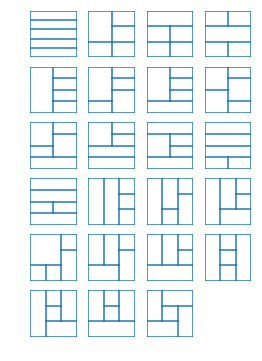

In [29]:
draw_matrices(five_cells, fig_cols=4)

In [30]:
six_cells = gather_rectangulations(6)

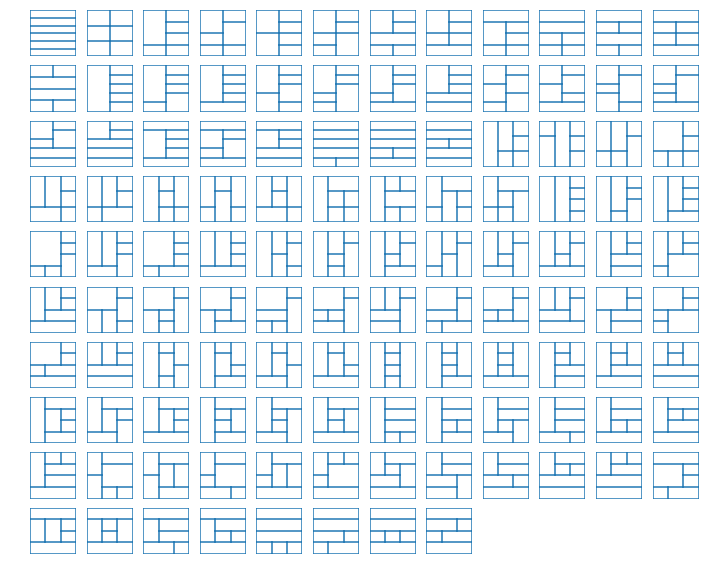

In [34]:
#draw_matrices(six_cells, fig_cols=12, save=True)
draw_matrices(six_cells, fig_cols=12)